/tmp/ipykernel_113784/3291919428.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = spi.quad(kernel, -10, 10)[0]  # Limiter l'intégration à [-10, 10]


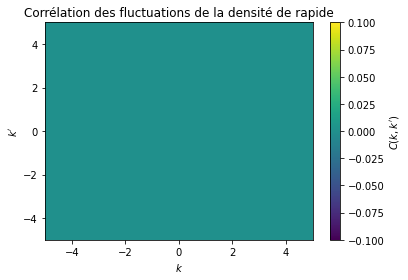

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
import numpy as np
import scipy.integrate as spi
import scipy.optimize as spo
import matplotlib.pyplot as plt

# Paramètres du modèle
L = 100  # Longueur du système
N = 10000  # Nombre de particules
c = 1.0  # Intensité de l'interaction
MCMC_steps = 100000  # Nombre d'itérations Monte Carlo

# Équation intégrale de Bethe pour obtenir rho(k)
def bethe_equation(rho_vals, k_vals, k, c):
    def kernel(kp):
        rho_kp = np.interp(kp, k_vals, rho_vals)  # Interpolation pour approximer rho(kp)
        return (1 / np.pi) * (2 * c / (c**2 + (k - kp)**2)) * rho_kp
    integral = spi.quad(kernel, -10, 10)[0]  # Limiter l'intégration à [-10, 10]
    rho_k = np.interp(k, k_vals, rho_vals)
    return rho_k + 1 / (2 * np.pi) * integral - 1 / (2 * np.pi)

# Discrétisation de k
k_vals = np.linspace(-5, 5, 200)

# Approximation de rho(k) avec une solution initiale
rho_solution = rho_init.copy()
tolerance = 1e-6
max_iterations = 100

for _ in range(max_iterations):
    rho_new = np.zeros_like(rho_solution)
    for i, k in enumerate(k_vals):
        rho_new[i] = bethe_equation(rho_solution, k_vals, k, c)  # Utilisation de la fonction directement
    if np.max(np.abs(rho_new - rho_solution)) < tolerance:
        break  # Convergence atteinte
    rho_solution = rho_new

# Génération des k_j par inversion de la densité cumulative
cdf = np.cumsum(rho_solution) / np.sum(rho_solution)
k_samples = np.interp(np.random.rand(N), cdf, k_vals)

# Monte Carlo Metropolis-Hastings pour fluctuation de rho(k)
def metropolis_hastings(k_samples, steps, delta=0.1):
    samples = []
    current_k = k_samples.copy()
    for _ in range(steps):
        k_new = current_k + delta * (2 * np.random.rand(N) - 1)
        acceptance_ratio = np.exp(-np.sum((k_new - current_k)**2) / (2 * delta**2))
        if np.random.rand() < acceptance_ratio:
            current_k = k_new
        samples.append(current_k.copy())
    return np.array(samples)

# Exécution du Monte Carlo
mc_samples = metropolis_hastings(k_samples, MCMC_steps)

# Calcul des fluctuations delta rho(k)
def compute_density_fluctuations(mc_samples, k_vals, bins=50):
    densities = np.array([np.histogram(sample, bins=bins, range=(min(k_vals), max(k_vals)))[0] for sample in mc_samples])
    mean_density = np.mean(densities, axis=0)
    delta_rho = densities - mean_density
    return delta_rho

# Matrice de covariance
fluctuations = compute_density_fluctuations(mc_samples, k_vals)
cov_matrix = np.cov(fluctuations.T)

# Affichage des résultats
plt.imshow(cov_matrix, extent=[-5, 5, -5, 5], origin='lower', aspect='auto')
plt.colorbar(label='$C(k, k\')$')
plt.xlabel('$k$')
plt.ylabel("$k'$")
plt.title('Corrélation des fluctuations de la densité de rapide')
plt.show()

print (cov_matrix)

In [19]:
import numpy as np
import scipy.integrate as spi
import scipy.optimize as spo
import matplotlib.pyplot as plt

# Paramètres du modèle
L = 10  # Longueur du système
N = 1000  # Nombre de particules
c = 1.0  # Intensité de l'interaction
MCMC_steps = 10000  # Nombre d'itérations Monte Carlo

# Fonction theta(k_j, k_m)
def scattering_phase(kj, km, c):
    return 2 * np.arctan((kj - km) / c)

# Équation de Bethe sous forme logarithmique
def bethe_equation(k_vals, L, c, n_vals):
    def equation(kj, k_vals, L, c, nj):
        sum_theta = np.sum([scattering_phase(kj, km, c) for km in k_vals])
        return kj * L + sum_theta - 2 * np.pi * nj
    
    return [spo.root_scalar(equation, args=(k_vals, L, c, n), bracket=[-10, 10]).root for n in n_vals]

# Discrétisation de n_j
n_vals = np.arange(-N//2, N//2)
k_vals = bethe_equation(n_vals, L, c, n_vals)

# Monte Carlo Metropolis-Hastings pour fluctuation de k_j
def metropolis_hastings(k_samples, steps, delta=0.1):
    samples = []
    current_k = k_samples.copy()
    for _ in range(steps):
        k_new = current_k + delta * (2 * np.random.rand(N) - 1)
        acceptance_ratio = np.exp(-np.sum((k_new - current_k)**2) / (2 * delta**2))
        if np.random.rand() < acceptance_ratio:
            current_k = k_new
        samples.append(current_k.copy())
    return np.array(samples)

# Exécution du Monte Carlo
mc_samples = metropolis_hastings(k_vals, MCMC_steps)

# Calcul des fluctuations delta rho(k)
def compute_density_fluctuations(mc_samples, k_vals, bins=50):
    densities = np.array([np.histogram(sample, bins=bins, range=(min(k_vals), max(k_vals)))[0] for sample in mc_samples])
    mean_density = np.mean(densities, axis=0)
    delta_rho = densities - mean_density
    return delta_rho

# Matrice de covariance
fluctuations = compute_density_fluctuations(mc_samples, k_vals)
cov_matrix = np.cov(fluctuations.T)

# Affichage des résultats
plt.imshow(cov_matrix, extent=[-5, 5, -5, 5], origin='lower', aspect='auto')
plt.colorbar(label='$C(k, k\')$')
plt.xlabel('$k$')
plt.ylabel("$k'$")
plt.title('Corrélation des fluctuations de la densité de rapide')
plt.show()


ValueError: f(a) and f(b) must have different signs

In [16]:
# Calcul de la moyenne et de l'écart-type de la matrice de covariance
mean_cov = np.mean(cov_matrix)
std_cov = np.std(cov_matrix)

print(f"Moyenne de cov_matrix : {mean_cov:.6f}")
print(f"Écart-type de cov_matrix : {std_cov:.6f}")


Moyenne de cov_matrix : 0.000000
Écart-type de cov_matrix : 0.000000
